In [3]:
# import the necessary packages
import numpy as np
import imutils
import cv2
import argparse
import os

In [29]:
class Stitcher:
    def __init__(self):# determine if we are using OpenCV v3.X
        self.isv3 = imutils.is_cv3(or_better=True)

    def stitch(self, images, ratio=0.75, reprojThresh=4.0,showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB) # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh) # if the match is None, then there aren’t enough matched
        # keypoints to create a panorama
        if M is None:
            return None
        (matches, H, status) = M
        print(f'A: {imageA.shape}, B: {imageB.shape}')
        print(f'H: {H}')
        result = cv2.warpPerspective(imageA, H,
                                     (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB  # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)  # return the stitched image
        return result

    def detectAndDescribe(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if self.isv3:  # detect and extract features from the image
            descriptor = cv2.xfeatures2d.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)  # otherwise, we are using OpenCV 2.4.X
        else:
            # detect keypoints in the image
            detector = cv2.FeatureDetector_create('SIFT')
            kps = detector.detect(gray)  # extract features from the image
            extractor = cv2.DescriptorExtractor_create('SIFT')
            (kps, features) = extractor.compute(gray, kps)
            # convert the keypoints from KeyPoint objects to NumPy arrays
            kps = np.float32([kp.pt for kp in kps])  # return a tuple of keypoints and features
        return (kps, features)


    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual matches
        matcher = cv2.DescriptorMatcher_create('BruteForce')
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []  # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe’s ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))  # computing a homography requires at least 4 matches
            if len(matches) > 4:
                # construct the two sets of points
#                 ptsA = [kpsA[i] for (_, i) in matches]
#                 ptsB = [kpsB[i] for (i, _) in matches]

#                 ptA = [iA.pt for iA in ptsA]
#                 ptB = [iB.pt for iB in ptsB]
                
                ptsA = np.float32([kpsA[i].pt for (_, i) in matches])
                ptsB = np.float32([kpsB[i].pt for (i, _) in matches])
                
                print(ptsA)
                print(ptsB)

                # compute the homography between the two sets of points
                (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
                # return the matches along with the homograpy matrix
                # and status of each matched point
                print(f'return :: {H}')
                
                return (matches, H, status)
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB    # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully matched
            if s == 1:
                # draw the match
                ptsA = (int(kpsA[queryIdx].pt[0]), int(kpsA[queryIdx].pt[1]))
                ptsB = (int(kpsB[trainIdx].pt[0]) + wA, int(kpsB[trainIdx].pt[1]))
                cv2.line(vis, ptsA, ptsB, (0, 255, 0), 1)
        return vis


In [30]:
import matplotlib.pyplot as plt
img = cv2.imread('./imgScene.jpg')
# imageA = cv2.imread('img1.jpg')
# imageB = cv2.imread('img2.jpg')
imageA = img[:,0:int(img.shape[1]/2)+200]
# plt.imshow(left)

imageB = img[:,int(img.shape[1]/2)-200:]
# plt.imshow(right)


# imageA = imutils.resize(imageA, width=400)
# imageB = imutils.resize(imageB, width=400)# stitch the images together to create a panorama
stitcher = Stitcher()
# (result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)# show the images
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)# show the images

[[  3.4006433 579.74664  ]
 [  3.4006433 579.74664  ]
 [  4.617512  271.584    ]
 [  5.8807197 251.45773  ]
 [  6.1817746 386.1607   ]]
[[443.41162 579.743  ]
 [443.41162 579.743  ]
 [444.6307  271.5219 ]
 [445.88602 251.45421]
 [446.18784 386.15054]]
return :: [[ 2.46746397e-01 -9.84972856e-03  4.40118903e+02]
 [-4.48852393e-01  9.75763405e-01  4.89974610e+00]
 [-1.64528086e-03 -2.21074213e-05  1.00000000e+00]]
A: (720, 840, 3), B: (720, 840, 3)
H: [[ 2.46746397e-01 -9.84972856e-03  4.40118903e+02]
 [-4.48852393e-01  9.75763405e-01  4.89974610e+00]
 [-1.64528086e-03 -2.21074213e-05  1.00000000e+00]]


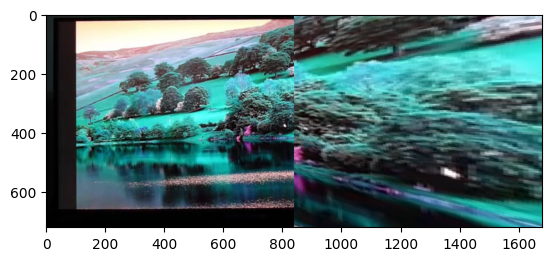

In [32]:

# cv2.imshow('Image A', imageA)
# cv2.imshow('Image B', imageB)
# cv2.imshow('Keypoint Matches', vis)
# cv2.imshow('Result', result)
plt.imshow(result)

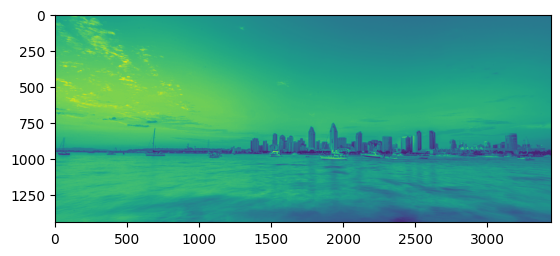

In [20]:
import matplotlib.pyplot as plt
img = cv2.imread('./image_wide.jpg', 0)
# print(img)
plt.imshow(img)

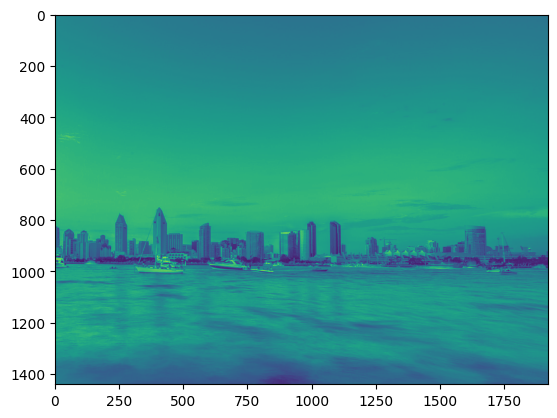

In [27]:
left = img[:,0:int(img.shape[1]/2)+200]
plt.imshow(left)

right = img[:,int(img.shape[1]/2)-200:]
plt.imshow(right)